# Application of VGG16: using VGGFace weights for Gender Classification




VGG base --> 128 layer--> Out <br>
VGG base is frozen upto block 4. Training on VGG base block 5 + Fully connected layers. <br>
VGGFace weights are loaded for VGG base initially. <br>
Image augmentation removed.

## 1. Dataset

In [1]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 41.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses
from keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import set_random_seed
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import keras_cv

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Setting the seed
seed = 42
set_random_seed(seed)
np.random.seed(42)

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [7]:
folder_path = "/content/drive/My Drive/UTKFace_retina_cropped_100x100"
#folder_path = "/content/drive/My Drive/zip files/extracted/UTKFace_retina_cropped_100x100"

In [8]:
cnt = 0
for file in sorted(os.listdir(folder_path)):  # Sort file list
  file_path = os.path.join(folder_path,file)
  cnt = cnt + 1

print(f"Number of face images: {cnt}")

Number of face images: 23561


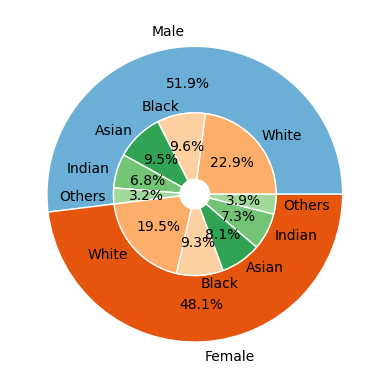

In [ ]:
# age: is an integer from 0 to 116, indicating the age
# gender: is either 0 (male) or 1 (female)
# race: is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

column_names = ['Age', 'Gender', 'Race']
records = []

for file in os.listdir(folder_path):
  records.append(file.split('_')[:-1])

DFrame=pd.DataFrame(records, columns=column_names).astype(int)

# EDA: Pie chart:
fig, ax = plt.subplots()
cmap = plt.colormaps["tab20c"]
outer_colors = cmap([1,4])
inner_colors = cmap([6,7,8,9,10, 6,7,8,9,10])
size = 0.45
pctdist = 0.75

# Counts all the people travelling in the spaceship
DF_tot = DFrame['Gender'].value_counts()

# Outer pie chart (to show distribution of age variable)
ax.pie(
    np.array(DF_tot),
    autopct='%1.1f%%',
    pctdistance = pctdist,
    radius=1.0,
    colors=outer_colors,
    wedgeprops=dict(width=size, edgecolor='w'),
    labels=['Male', 'Female']    #[0, 1]
     #[df_tot.index[0],df_tot.index[1]]  #[True, False]
);

# Counts of races in females
DF_F = DFrame.Race[DFrame['Gender']==1].value_counts()

# Counts of races in males
DF_M = DFrame.Race[DFrame['Gender']==0].value_counts()

# Concatenate arrays, for use in inner pie chart
concat_arrays= np.concatenate((np.array(DF_M), np.array(DF_F)))  #T, F

# Inner pie chart (to show sub-distribution of "race")
ax.pie(
    concat_arrays,
    autopct='%1.1f%%',
    radius=1.0-size,
    colors=inner_colors,
    wedgeprops=dict(width=size, edgecolor='w'),
    #labels=['0','4','0']
    labels=['White','Black','Asian','Indian', 'Others',
            'White','Black','Asian','Indian', 'Others',]   #White, Black, Asian, Indian, and Others
);

Text(0.5, 1.0, 'Distribution of gender in the UTKFace dataset')

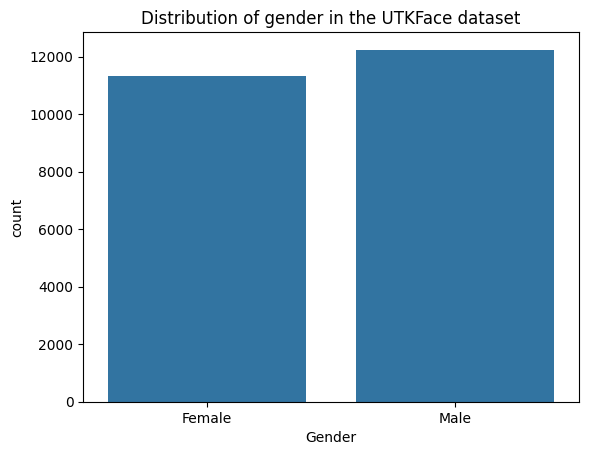

In [ ]:
gender_mapping = {
    0: 'Male',
    1: 'Female'
}

DF = DFrame.copy()

# Replace the integers with correct gender
DF['Gender'] = DF['Gender'].replace(gender_mapping)

# Count plot
plt.figure()
sns.countplot(x='Gender', data=DF)
plt.title('Distribution of gender in the UTKFace dataset')

In [ ]:
def read_image(fname):
    parts = tf.strings.split(fname, os.sep)
    file_name = parts[-1]

    # Split by underscores to extract the label, add validation
    multiple_labels = tf.strings.split(file_name, '_')

    gender_label = multiple_labels[1]

    # Convert to integer label safely
    label = tf.strings.to_number(gender_label, out_type=tf.int32)

    # Load and decode the image
    image = tf.io.read_file(fname)
    image = tf.io.decode_jpeg(image)
    return image, label

In [ ]:
# Creating training, validation and test sets...
list_ds = tf.data.Dataset.list_files(folder_path + "/*")

# Total number of files
file_count = len(list_ds)

# Define split sizes
train_size = int(0.8 * file_count)  # 80% for training
val_size = int(0.1 * file_count)    # 10% for validation
test_size = file_count - train_size - val_size  # Remaining 10% for testing

# Shuffle the dataset before splitting
list_ds = list_ds.shuffle(buffer_size=file_count, seed=42)

# Split into training, validation, and test datasets
train_list_ds = list_ds.take(train_size)  # First 80% for training
val_list_ds = list_ds.skip(train_size).take(val_size)  # Next 10% for validation
test_list_ds = list_ds.skip(train_size + val_size)  # Remaining 10% for test

# for element in list_ds.as_numpy_iterator():
#   print(element)
#   break

In [ ]:
# Example check
for image, label in list_ds.map(read_image).take(5):
    print("Label:", label)

Label: tf.Tensor(1, shape=(), dtype=int32)
Label: tf.Tensor(0, shape=(), dtype=int32)
Label: tf.Tensor(0, shape=(), dtype=int32)
Label: tf.Tensor(0, shape=(), dtype=int32)
Label: tf.Tensor(0, shape=(), dtype=int32)


Gender label: 0
(100, 100, 3)


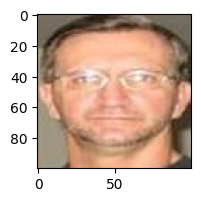

In [ ]:
for element in list_ds.as_numpy_iterator():
  img, lab = read_image(element)
  fig, ax = plt.subplots(figsize=(2,2))
  ax.imshow(img)
  print(f'Gender label: {lab.numpy()}')
  print(img.shape)
  break

In [ ]:
# Define the rotation layer outside the function for reuse
rotation_layer = keras_cv.layers.RandomRotation(factor=0.111)  # 0.111 ~= 20 degrees

# RGB mean values to subtract

mean_vector = [91.4953, 103.8827, 131.0912]

def preprocess_image(image, label, augment=True, mean_vector=mean_vector):
    # Convert image to float32 and normalize to [0,1] if not already done in the dataset pipeline
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    if augment:
        # Apply augmentation
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        image = tf.image.random_hue(image, max_delta=0.05)

        # Rotate up to 20 degrees using KerasCV
        image = rotation_layer(image)

    # Subtract RGB mean values
    mean_values = tf.constant(mean_vector, dtype=tf.float32)
    image = image - mean_values / 255.0  # Normalize mean values to [0,1] scale

    return image, label


In [ ]:
"""
# Define the rotation layer outside the function for reuse
rotation_layer = keras_cv.layers.RandomRotation(factor=0.111)  # 0.111 ~= 20 degrees

def preprocess_image(image, label, augment=True):
    #image = tf.image.convert_image_dtype(image, dtype=tf.float32)  # Normalize to [0,1]

    if augment:
        # Apply augmentation
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        image = tf.image.random_hue(image, max_delta=0.05)

        # Rotate up to 20 degrees using KerasCV
        image = rotation_layer(image)

    return image, label
"""

'\n# Define the rotation layer outside the function for reuse\nrotation_layer = keras_cv.layers.RandomRotation(factor=0.111)  # 0.111 ~= 20 degrees\n\ndef preprocess_image(image, label, augment=True):\n    #image = tf.image.convert_image_dtype(image, dtype=tf.float32)  # Normalize to [0,1]\n\n    if augment:\n        # Apply augmentation\n        image = tf.image.random_flip_left_right(image)\n        image = tf.image.random_brightness(image, max_delta=0.2)\n        image = tf.image.random_contrast(image, lower=0.7, upper=1.3)\n        image = tf.image.random_saturation(image, lower=0.8, upper=1.2)\n        image = tf.image.random_hue(image, max_delta=0.05)\n\n        # Rotate up to 20 degrees using KerasCV\n        image = rotation_layer(image)\n\n    return image, label\n'

In [ ]:
# Batch size for training
batch_size = 128

# Preparing the datasets
train_ds = (
    train_list_ds
    .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, lbl: preprocess_image(img, lbl, augment=False), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

# Validation dataset without augmentation
val_ds = (
    val_list_ds
    .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, lbl: preprocess_image(img, lbl, augment=False), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

# Test dataset without augmentation
test_ds = (
    test_list_ds
    .map(read_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(lambda img, lbl: preprocess_image(img, lbl, augment=False), num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

## 2. Building a CNN using Transfer Learning on VGG model
Input image shape: (100, 100, 3)

Let's include VGG16 model without the top

In [ ]:
img_input = layers.Input((100, 100, 3), dtype='float32', name='base_model')
# Block 1
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(img_input)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

# Block 2
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

# Block 3
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

# Block 4
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

# Block 5
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)

# Define the base model
base_model = models.Model(inputs=img_input, outputs=x, name='base_vgg_model')

#weights_path = 'https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_tf_notop_vgg16.h5'
# https://github.com/rcmalli/keras-vggface/tree/master


weights_path = "/content/drive/My Drive/VGGFace weights/rcmalli_vggface_tf_notop_vgg16.h5"
#https://github.com/rcmalli/keras-vggface/releases
base_model.load_weights(weights_path)

for layer in base_model.layers[:15]:
    layer.trainable = False


# Number of output classes (customize this based on your problem)
num_classes = 2  # Replace with the actual number of classes

# Build custom classification layers on top of the frozen base model
x_in = base_model.output
x = layers.Reshape((-1,))(x_in)  # Reshape to a single vector
x = layers.Dense(128, activation='relu')(x)
out = layers.Dense(num_classes, activation='softmax')(x)

# Combine base model and custom layers
model = models.Model(inputs=base_model.input, outputs=out, name='custom_VGG_model')

# Print the full custom model summary
print("\nMy ResNet model with custom classifier:")
model.summary()


My ResNet model with custom classifier:


Model: "custom_VGG_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ base_model (InputLayer)              │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_1 (Conv2D)                     │ (None, 100, 100, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_2 (Conv2D)                     │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_1 (Conv2D)                     │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_2 (Conv2D)                     │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_1 (Conv2D)                     │ (None, 25, 25, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_2 (Conv2D)                     │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_3 (Conv2D)                     │ (None, 25, 25, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4_1 (Conv2D)                     │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4_2 (Conv2D)                     │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4_3 (Conv2D)                     │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling2D)                 │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv5_1 (Conv2D)                     │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv5_2 (Conv2D)                     │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv5_3 (Conv2D)                     │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool5 (MaxPooling2D)                 │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,304,898 (58.38 MB)

 Trainable params: 7,669,634 (29.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
# Print layer numbers and details
cnt = 1
for layer in model.layers:
    print(f'{cnt}: {layer.name} - {"Trainable" if layer.trainable else "Frozen"}')
    cnt += 1


1: base_model - Frozen
2: conv1_1 - Frozen
3: conv1_2 - Frozen
4: pool1 - Frozen
5: conv2_1 - Frozen
6: conv2_2 - Frozen
7: pool2 - Frozen
8: conv3_1 - Frozen
9: conv3_2 - Frozen
10: conv3_3 - Frozen
11: pool3 - Frozen
12: conv4_1 - Frozen
13: conv4_2 - Frozen
14: conv4_3 - Frozen
15: pool4 - Frozen
16: conv5_1 - Trainable
17: conv5_2 - Trainable
18: conv5_3 - Trainable
19: pool5 - Trainable
20: reshape - Trainable
21: dense - Trainable
22: dense_1 - Trainable


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the checkpoint path in Google Drive
checkpoint_path = '/content/drive/MyDrive/model_checkpoints/best_weights_442.keras'

# Create the checkpoint callback
mc_callback = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy',
                              save_best_only=True, mode='max')

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.01))

lr_callback = LearningRateScheduler(scheduler)


# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
# My model’s last layer has a softmax activation, thus from_logits=False

In [ ]:
history = model.fit(train_ds, epochs=10,
                    batch_size=batch_size, validation_data=val_ds,
                    callbacks=[mc_callback, lr_callback])  #batch_size=128

Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 6857s 46s/step - accuracy: 0.8252 - loss: 0.3830 - val_accuracy: 0.9261 - val_loss: 0.2097 - learning_rate: 1.0000e-04
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 26s 174ms/step - accuracy: 0.9110 - loss: 0.2143 - val_accuracy: 0.9402 - val_loss: 0.1696 - learning_rate: 1.0000e-04
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 40s 168ms/step - accuracy: 0.9455 - loss: 0.1495 - val_accuracy: 0.9440 - val_loss: 0.1470 - learning_rate: 1.0000e-04
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.9697 - loss: 0.0906 - val_accuracy: 0.9346 - val_loss: 0.1683 - learning_rate: 1.0000e-04
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 25s 167ms/step - accuracy: 0.9739 - loss: 0.0734 - val_accuracy: 0.9737 - val_loss: 0.0861 - learning_rate: 1.0000e-04
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 39s 153ms/step - accuracy: 0.9770 - loss: 0.0586 - val_accuracy: 0.9673 - val_loss: 0.0991 - learning_rate: 1.0000e-04
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 42s 16

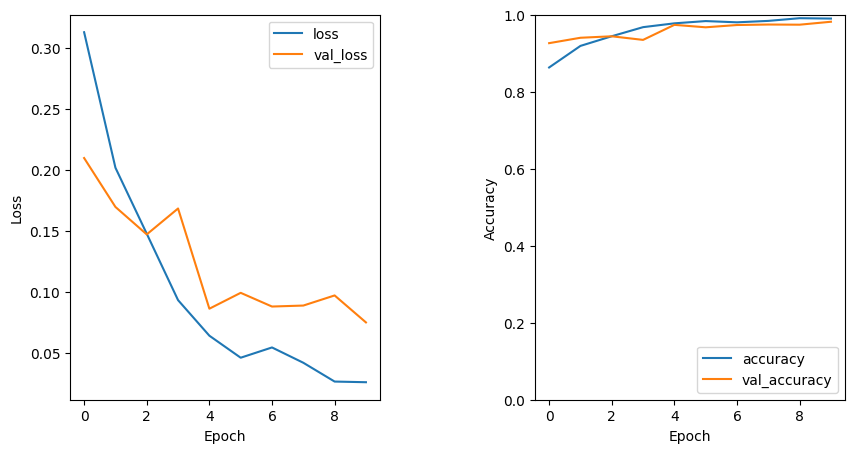

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
plt.subplots_adjust(hspace=0.1, wspace=0.5)

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label = 'val_loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='upper right')

axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label = 'val_accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 1])
axs[1].legend(loc='lower right')

### Evaluating the model

In [ ]:
#Loading the weights of the model with best validation accuracy
model.load_weights(checkpoint_path)
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print("")
print(f"test_loss = {np.round(test_loss,4)}, test_acc = {np.round(test_acc,4)}")

19/19 - 239s - 13s/step - accuracy: 0.9818 - loss: 0.0696

test_loss = 0.0696, test_acc = 0.9818


### Visualising some predictions made by VGG16 model

In [ ]:
def unpreprocess_image(image, mean_vector=[91.4953, 103.8827, 131.0912]):
    # Add back the RGB mean values (undoing the mean subtraction and normalization)
    mean_values = tf.constant(mean_vector, dtype=tf.float32)
    image = image + (mean_values / 255.0)  # Revert the mean subtraction

    # Convert back to original image dtype (e.g., uint8) if needed
    image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
    return image

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step


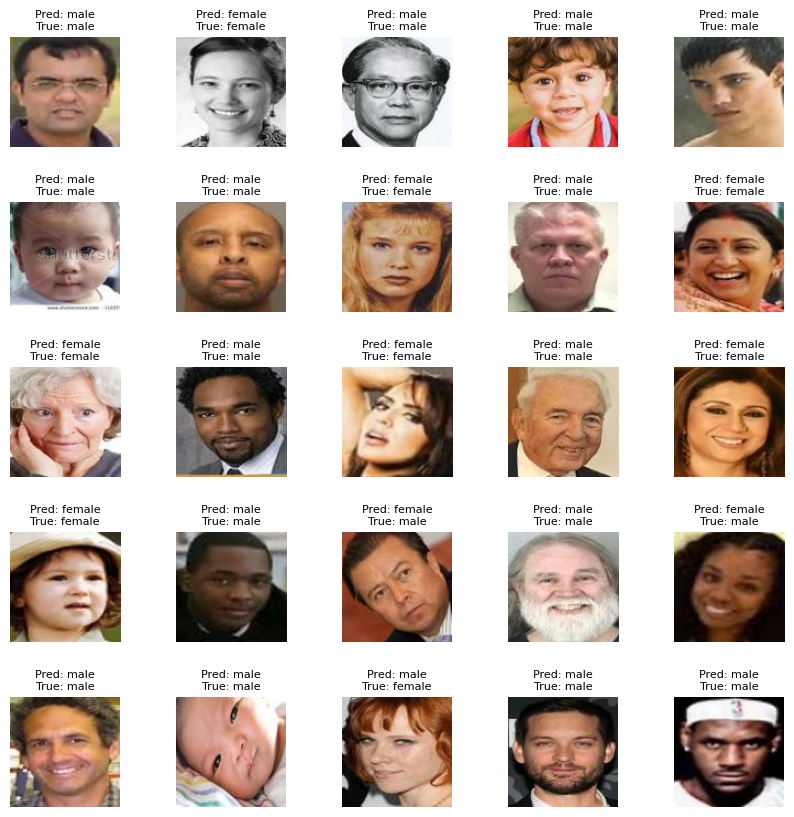

In [ ]:
string_labels = ['male', 'female']

# First, get predictions for validation images
predicted_scores = model.predict(test_ds)
predicted_labels = np.argmax(predicted_scores, axis=1)

# Convert numerical labels back to class names
index_to_label = [string_labels[label] for label in predicted_labels]

# Initialize lists to store images and labels
true_labels = []
images = []

# Loop through test_ds to collect images and labels
for image_batch, label_batch in test_ds:
    images.append(image_batch.numpy())  # Convert to NumPy array
    true_labels.append(label_batch.numpy())

# Convert the list of arrays into a single NumPy array for each
images = np.concatenate(images, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Select 25 random indices from the test set
random_indices = np.random.choice(len(images), size=25, replace=False)

# Plot the selected images with predicted and true labels
f, ax = plt.subplots(5, 5, figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
ax = ax.ravel()

for i, idx in enumerate(random_indices):
    ax[i].imshow(unpreprocess_image(images[idx]))
    ax[i].set_title(f"Pred: {string_labels[predicted_labels[idx]]}\nTrue: {string_labels[true_labels[idx]]}")
    ax[i].title.set_size(8)
    ax[i].axis('off')

plt.show()

### Visualising the confusion matrix

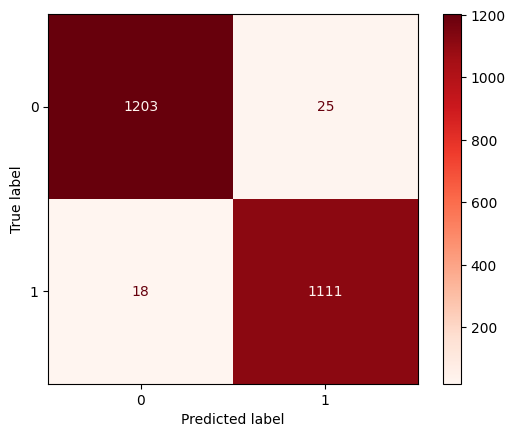

In [ ]:
y_pred= [label for label in predicted_labels]
y_true = [label for label in true_labels]

classes = np.arange(2)
cm = confusion_matrix(y_true, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Reds')

### Classification report

In [ ]:
# Use classification_report to get precision and recall
classification_report_result = classification_report(y_true, y_pred)

print("\nClassification Report:")
print(classification_report_result)


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1228
           1       0.98      0.98      0.98      1129

    accuracy                           0.98      2357
   macro avg       0.98      0.98      0.98      2357
weighted avg       0.98      0.98      0.98      2357

